<a href="https://colab.research.google.com/github/borankilic/fake-news-detection/blob/main/fake_news_detection_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEUROMATCH 2024 - NATURAL LANGUAGE PROCESSING
# A Novel Approach For Detecting Fake News using Deep Learning Methods

### Pod: Tranquil Kolwitzia / Project Group 1

- **Boran Aybak Kilic**
- Zeinab Jalilzadeh
- Ali Khezri





In [ ]:
# @title Install dependencies
!pip install pandas --quiet
!pip install torchtext --quiet
!pip install text_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
# @title Import Required Libraries
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import vocab
from collections import Counter, OrderedDict

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

# Load and Explore the Dataset


In [ ]:
# @title Download the dataset from the Kaggle and extract the zip-file
! kaggle datasets download -d emineyetm/fake-news-detection-datasets

Dataset URL: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
License(s): unknown
 98% 40.0M/41.0M [00:03<00:00, 10.9MB/s]
100% 41.0M/41.0M [00:03<00:00, 11.8MB/s]


In [ ]:
import requests, zipfile, os
file_name = 'fake-news-detection-datasets.zip'
raw_data_dir = '/content/News_dataset'

if not os.path.isdir(raw_data_dir):
  with zipfile.ZipFile(file_name, 'r') as zip:
      # printing all the contents of the zip file
      zip.printdir()

      # extracting all the files
      print('Extracting all the files now...')
      zip.extractall()

File Name                                             Modified             Size
News _dataset/Fake.csv                         2022-12-07 11:45:26     62789876
News _dataset/True.csv                         2022-12-07 11:45:32     53582940
Extracting all the files now...


In [ ]:
# We load the dataset

fake_df = pd.read_csv('/content/News _dataset/Fake.csv',
                 encoding = "ISO-8859-1")
true_df = pd.read_csv('/content/News _dataset/True.csv',
                 encoding = "ISO-8859-1")

# Let's have a look at it
true_df.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [ ]:
import requests, zipfile, os
file_name = '/content/fake-news-detection-datasets.zip'
raw_data_dir = '/content/test_dataset/'

if not os.path.isdir(raw_data_dir):
  with zipfile.ZipFile(file_name, 'r') as zip:
      # printing all the contents of the zip file
      zip.printdir()

      # extracting all the files
      print('Extracting all the files now...')
      zip.extractall()
#data_df = pd.read_csv('fake-news-detection-datasets.csv',
#                 encoding = "ISO-8859-1")
#data_df.columns

File Name                                             Modified             Size
News _dataset/Fake.csv                         2022-12-07 11:45:26     62789876
News _dataset/True.csv                         2022-12-07 11:45:32     53582940
Extracting all the files now...


In [ ]:
# @markdown we can alternatively choose to consider only one category of news
fake_df.subject.value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

# Preprocessing of Data

**Label each new as 1 if it's fake and 0 if true**




In [ ]:
# @title Let's first concatanate fake_df and true_df and also drop subject, date , title_length colums

fake_df['label'] = 1
true_df['label'] = 0
news_df =  pd.concat([fake_df, true_df], ignore_index=True)

news_df = news_df.drop(['subject', 'date'], axis=1)

news_df.head()

print(f'Number of rows: {len(news_df)}')
news_df.tail()



Number of rows: 44898


,title,text,label
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,0
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,0


We can only take the text columns to consideration or we can concatanate the title and text colums to be processed by our deep neural network.

Uncomment the code block accordingly.

In [ ]:
## Only include the title
#news_df = news_df.drop(['text'], axis=1)

# Concatanate title and text colums
try:
  news_df['content'] = news_df['title'] + ' ' + news_df['text']
  news_df = news_df.drop(['title', 'text'], axis=1)
except KeyError:
  pass
# Drop title and text colums

news_df.reset_index(drop=True, inplace=True)
news_df.tail()



,label,content
6330,0,State Department says it can't find emails fro...
6331,1,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,1,Anti-Trump Protesters Are Tools of the Oligarc...
6333,0,"In Ethiopia, Obama seeks progress on peace, se..."
6334,0,Jeb Bush Is Suddenly Attacking Trump. Here's W...


In [ ]:
# @title Let's see how a typical sentence looks like
import pprint
print(news_df.content[0])


You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. 
The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. 
The FBI’s leadership is bein

As you can see we have lot of redundant words and characters. We need to clean the text so that we're left with a pure input from which we can infer meaning.

In [ ]:
# @title Remove the word 'Reuters' from the text
# @markdown Since all the true news are collected from Reuters.com, most of them contain the tag reuters. We should delete all instances of this tag in order make the model learn essential features rather than just classifying them based on containing the reuters tag or not.
count_before = news_df['content'].str.count('Reuters').sum()
news_df['content'] = news_df['content'].str.replace('Reuters', '', regex=False)
news_df['content'] = news_df['content'].str.replace('reuters', '', regex=False)
news_df['content'] = news_df['content'].str.replace('Reuter', '', regex=False)
news_df['content'] = news_df['content'].str.replace('reuter', '', regex=False)
count_after = news_df['content'].str.count('Reuters').sum()

print(f"Total instances of the word 'Reuters': {count_before}")
print(f"Total instances of the word 'Reuters': {count_after}")

Total instances of the word 'Reuters': 259
Total instances of the word 'Reuters': 0


##Text Preprocessing

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer    # lemmatize
from wordcloud import WordCloud, STOPWORDS
import string
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def remove_whitespaces(text):
    return ' '.join(text.split())

# Example usage
news_df['content'] = news_df['content'].apply(remove_whitespaces)
news_df

,label,content
0,1,you can smell hillarys fear daniel greenfield ...
1,1,watch the exact moment paul ryan committed pol...
2,0,kerry to go to paris in gesture of sympathy us...
3,1,bernie supporters on twitter erupt in anger ag...
4,0,the battle of new york why this primary matter...
...,...,...
6330,0,state department says it can not find emails f...
6331,1,the p in pbs should stand for plutocratic or p...
6332,1,antitrump protesters are tools of the oligarch...
6333,0,in ethiopia obama seeks progress on peace secu...


In [ ]:
# @title Expanding Contractions

def text_preproces(x):
    x = str(x).lower()
    x = x.replace('%',' percent').replace('₹',' rupee').replace('$',' dollar').replace('€',' euro')\
                                .replace(',000,000','m').replace('000','k').replace('′',"'").replace("’","'")\
                                .replace("won't","will not").replace("can't",'can not').replace("shouldn't","should not")\
                                .replace("what's",'"what is"').replace("that's",'that is').replace("he's","he is")\
                                .replace("she's","she is").replace("it's","it is").replace("'ve"," have").replace("'re"," are")\
                                .replace("'ll"," will").replace("i'm","i am").replace("n't", " not")
    x = re.sub(r'([0-9]+)000000',r'\1m',x)
    x = re.sub(r'([0-9]+)000',r'\1k',x)

    return x

def extract_features(df):
    df['content'] = df['content'].fillna("").apply(text_preproces)
    print("token features...")

    return df
news_df = extract_features(news_df)
news_df.head()

token features...


,label,content
0,1,you can smell hillary's fear daniel greenfield...
1,1,watch the exact moment paul ryan committed pol...
2,0,kerry to go to paris in gesture of sympathy u....
3,1,bernie supporters on twitter erupt in anger ag...
4,0,the battle of new york: why this primary matte...


In [ ]:
# @title Removal of URLs

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

news_df.content=news_df.content.apply(remove_urls)

news_df.head()


,label,content
0,1,you can smell hillary's fear daniel greenfield...
1,1,watch the exact moment paul ryan committed pol...
2,0,kerry to go to paris in gesture of sympathy u....
3,1,bernie supporters on twitter erupt in anger ag...
4,0,the battle of new york: why this primary matte...


In [ ]:
# @title Removal of HTML tags

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

news_df.content=news_df.content.apply(remove_html)

In [ ]:
# @title Removal of Usernames

def remove_usernames(text):
  """Removes usernames starting with '@' from a given text."""
  pattern = r'(@\w+)'  # Matches '@' followed by one or more word characters
  return re.sub(pattern, '', text)


news_df.content=news_df.content.apply(remove_usernames)
news_df

,label,content
0,1,you can smell hillary's fear daniel greenfield...
1,1,watch the exact moment paul ryan committed pol...
2,0,kerry to go to paris in gesture of sympathy u....
3,1,bernie supporters on twitter erupt in anger ag...
4,0,the battle of new york: why this primary matte...
...,...,...
6330,0,state department says it can not find emails f...
6331,1,the ‘p' in pbs should stand for ‘plutocratic' ...
6332,1,anti-trump protesters are tools of the oligarc...
6333,0,"in ethiopia, obama seeks progress on peace, se..."


In [ ]:
news_df['content'].str.count('@').sum()

30158057

In [ ]:
# @title Removal of Stopwords --- (dont run this not working properly)
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def remove_stopwords(lst):
    stop=stop_words
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

#news_df.content=news_df.content.apply(remove_stopwords)
#news_df

In [ ]:
news_df.content[6000]

"globalization expressway to universal slavery if humans were largely moral and ethical beings, then globalization could be a workable proposition. unfortunately, the dark behavioral narcissism expressed by compulsive greed and an infinite appetite for power seems to have become the guiding precept of our collective nightmare. if only the desire to dominate others and have a lot more than them were not the prime motivations for the global elite on top of the human food chain, we could all have our respective modest slice of happiness on this planet. the utopia of globalization through institutions such as the united nations (un), world bank , and international monetary fund (imf) was supposed to eradicate the universal pestilence of war, extreme poverty , hunger and slavery using the might of the above supranational institutions to prevent the rise of so-called rogue nations usually ruled by dictators. world order of chaos with misery for profit the opportunity of this push for a supra

In [ ]:

from text_preprocessing import preprocess_text
from text_preprocessing import remove_number, remove_punctuation, normalize_unicode, remove_email, remove_special_character

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def heavy_preprocessing(df):
  preprocess_functions = [normalize_unicode, remove_special_character, remove_email,  remove_punctuation ,remove_number]
  new_content = []
  for article in df.content:
    new_article = preprocess_text(article, preprocess_functions)
    new_content.append(new_article)
  df.content = new_content
  return df

heavy_preprocessing(news_df)
news_df

,label,content
0,1,you can smell hillarys fear daniel greenfield ...
1,1,watch the exact moment paul ryan committed pol...
2,0,kerry to go to paris in gesture of sympathy us...
3,1,bernie supporters on twitter erupt in anger ag...
4,0,the battle of new york why this primary matter...
...,...,...
6330,0,state department says it can not find emails f...
6331,1,the p in pbs should stand for plutocratic or p...
6332,1,antitrump protesters are tools of the oligarch...
6333,0,in ethiopia obama seeks progress on peace secu...


In [ ]:
import zipfile

def zip_csv(csv_file, output_zip):
  with zipfile.ZipFile(output_zip, 'w') as zipf:
    zipf.write(csv_file)

zip_csv('news_df_processed.csv', 'news_df_processed.zip')

In [ ]:
# @title Removal of Stopwords --- (takes way too much time to run)
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [ ]:
# @title Remove Extra Words --- (takes way too much time to run on CPU)

def remove_extrawords(lst):
    stop=['href','lt','gt','ii','iii','ie','quot','com']   ## This all words are most repeated words as we observed in WordCloud and it does not make any sense
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst


news_df.content=news_df.content.apply(remove_extrawords)

In [ ]:
# @title Removal of Punctuation --- (takes way too much time to run on CPU)
def remove_punctuations(lst):
  new_lst=[]
  for i in lst:
      for j in  string.punctuation:
          i=i.replace(j,'')
      new_lst.append(i)
  return new_lst
#news_df.content=news_df.content.apply(remove_punctuations)

In [ ]:
# @title Removal of Digits --- (takes way too much time to run on CPU)

def remove_numbers(lst):
    nodig_lst=[]
    new_lst=[]

    for i in  lst:
        for j in  string.digits:
            i=i.replace(j,'')
        nodig_lst.append(i)
    for i in  nodig_lst:
        if  i!='':
            new_lst.append(i)
    return new_lst
#news_df.content=news_df.content.apply(remove_punctuations)

In [ ]:
# @title Lemmatzation --- (takes way too much time to run)
lemmatizer = WordNetLemmatizer()

def lemmatzation(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst
news_df.content=news_df.content.apply(lemmatzation)

# Visualise and Export the Data

In [ ]:
# @title Let's see how a typical sentence looks like
import pprint
pprint.pprint(news_df.content[0])

(' donald trump sends out embarrassing new yearas eve message this is '
 'disturbing donald trump just couldn t wish all americans a happy new year '
 'and leave it at that instead he had to give a shout out to his enemies '
 'haters and  the very dishonest fake news media  the former reality show star '
 'had just one job to do and he couldn t do it as our country rapidly grows '
 'stronger and smarter i want to wish all of my friends supporters enemies '
 'haters and even the very dishonest fake news media a happy and healthy new '
 'year  president angry pants tweeted   will be a great year for america as '
 'our country rapidly grows stronger and smarter i want to wish all of my '
 'friends supporters enemies haters and even the very dishonest fake news '
 'media a happy and healthy new year  will be a great year for america  donald '
 'j trump  december  trump s tweet went down about as welll as you d '
 'expectwhat kind of president sends a new year s greeting like this '
 'despi

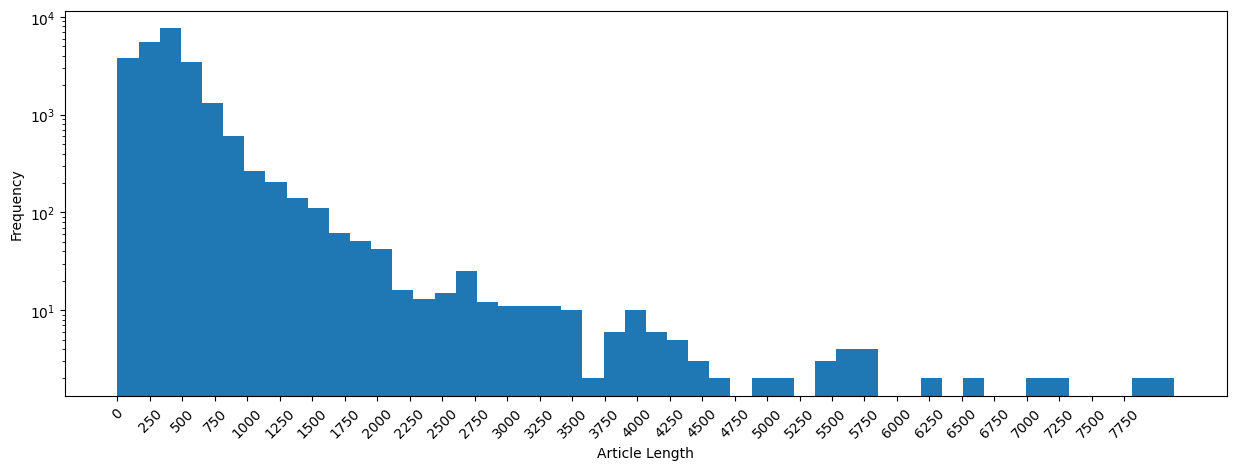

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist([len(article.split()) for article in fake_df.text], bins=50)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xlabel('Article Length')
ax.set_ylabel('Frequency')
ax.set_xticks(range(0, 8000, 250))
ax.set_xticklabels(range(0, 8000, 250), rotation=45)
plt.show()


In [ ]:
numbers = [len(article.split()) for article in fake_df.text]
import statistics




# Calculate mean
mean_value = statistics.mean(numbers)
print(f'Mean: {mean_value}')

# Calculate median
median_value = statistics.median(numbers)
print(f'Median: {median_value}')

# Calculate standard deviation
std_dev_value = statistics.stdev(numbers)
print(f'Standard Deviation: {std_dev_value}')


Mean: 423.1979046888974
Median: 363
Standard Deviation: 408.3888904366352


AttributeError: 'Figure' object has no attribute 'set_title'

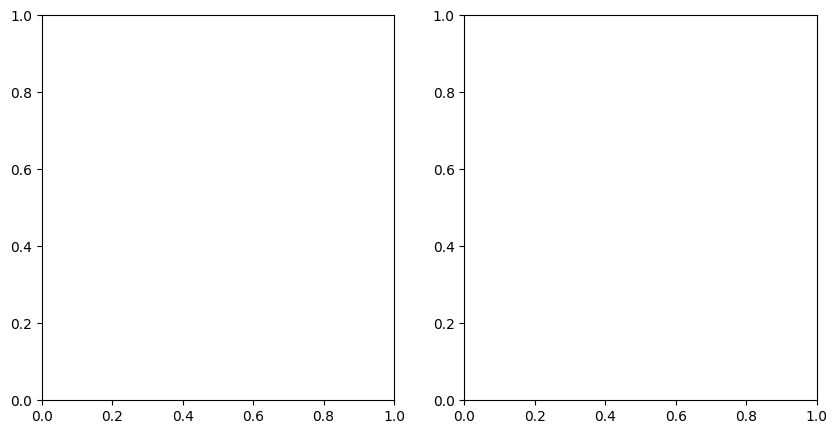

In [ ]:
# Concatenate all text in the DataFrame into a single string
fake_text = ' '.join(fake_df['text'].tolist())
true_text = ' '.join(true_df['text'].tolist())
# Generate the word cloud
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)


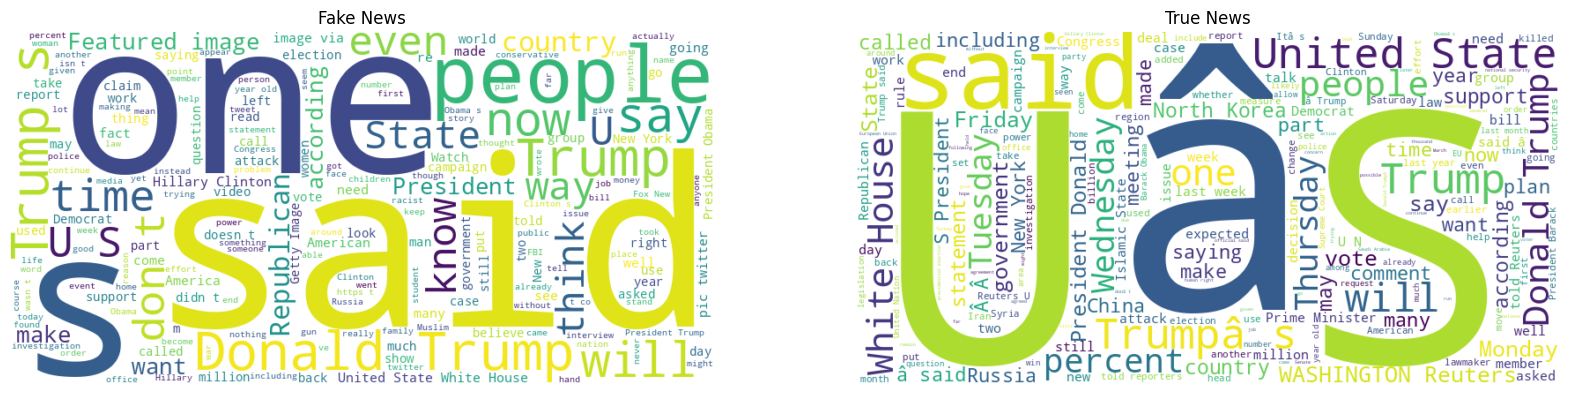

In [ ]:
# @title Display the word cloud
fig, (ax1, ax2)= plt.subplots(1,2,figsize=(20, 10))
ax1.set_title('Fake News')
ax2.set_title('True News')
ax1.imshow(fake_wordcloud, interpolation='bilinear')
ax1.axis('off')  # Hide the axes
ax2.imshow(true_wordcloud, interpolation='bilinear')
ax2.axis('off')  # Hide the axes
plt.show()

In [ ]:
# @title Export the Dataset
news_df.to_csv('news_df_valdata3.csv', index=False)